<a href="https://colab.research.google.com/github/matusoff/ML_models/blob/main/Providing_data_driven_suggestions_for_HR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business scenario and problem
The HR department wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They ask to provide data-driven suggestions based on the data. They have the following question: what’s likely to make the employee leave the company?



In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# For saving models
import pickle

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv("/content/sample_data/HR_capstone_dataset.csv")


# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Exploration (Initial EDA and data cleaning)

In [3]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Gather descriptive statistics about the data
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
# Rename columns

# Display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
# Rename columns as needed
df0.rename(columns={'Work_accident': 'work_accident', 'Department': 'employee_department', 'time_spend_company': 'employee_tenure', 'salary' : 'salary_level', 'left':'employee_left', 'average_montly_hours': 'average_monthly_hours'}, inplace=True)

# Display all column names after the update
print(df0.columns)
df0.head()

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'employee_tenure', 'work_accident',
       'employee_left', 'promotion_last_5years', 'employee_department',
       'salary_level'],
      dtype='object')


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,employee_tenure,work_accident,employee_left,promotion_last_5years,employee_department,salary_level
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


##Check missing and duplicate values

In [7]:
# Check for missing values
print(f"Number of missing values: {df0.isna().any(axis=1).sum()}")

Number of missing values: 0


In [8]:
# Check for duplicates
df0.duplicated().sum()

3008

In [9]:
# Inspect some rows containing duplicates as needed
duplicate_rows = df0[df0.duplicated()]
duplicate_rows

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,employee_tenure,work_accident,employee_left,promotion_last_5years,employee_department,salary_level
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [10]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df = df0.drop_duplicates(keep='first')
print(df.shape)
# Display first few rows of new dataframe as needed
df.head()

(11991, 10)


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,employee_tenure,work_accident,employee_left,promotion_last_5years,employee_department,salary_level
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Check outliers

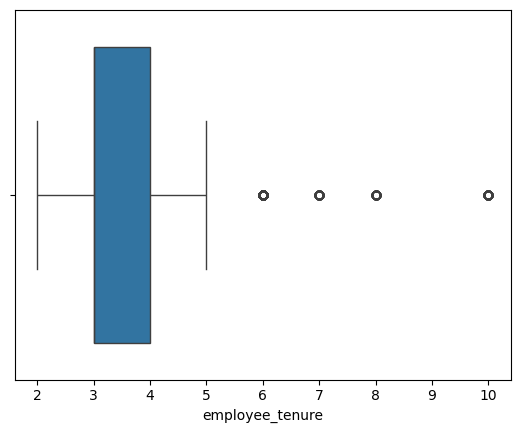

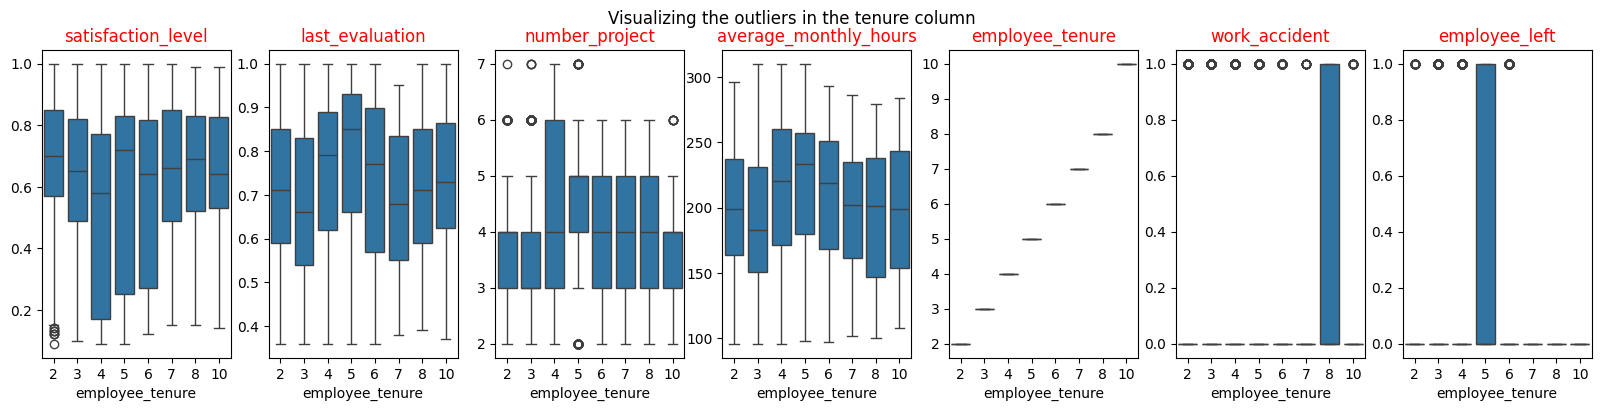

In [11]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
sns.boxplot(x=df['employee_tenure'])

# Check outliers in employee_tenure in relation to other columns
plt.figure(figsize=(20,4))
plt.style.use('default')
plt.suptitle('Visualizing the outliers in the tenure column')
for i in range(7):
    plt.subplot(1, 7, i+1)
    sns.boxplot(x=df['employee_tenure'], y=df.iloc[:, i])
    plt.title(df.columns[i], color='red')
    plt.ylabel('')


In [12]:
# Determine the number of rows containing outliers

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['employee_tenure'].quantile(0.25)
Q3 = df['employee_tenure'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['employee_tenure'] < lower_bound) | (df['employee_tenure'] > upper_bound)]

# Count outliers
num_outliers = outliers.shape[0]

print(f"Number of outliers in the column: {num_outliers}")

Number of outliers in the column: 824


In [13]:
# Get numbers of people who left vs. stayed
print(df['employee_left'].value_counts())

# Get percentages of people who left vs. stayed
print(df['employee_left'].value_counts() / 11991 * 100)

0    10000
1     1991
Name: employee_left, dtype: int64
0    83.39588
1    16.60412
Name: employee_left, dtype: float64


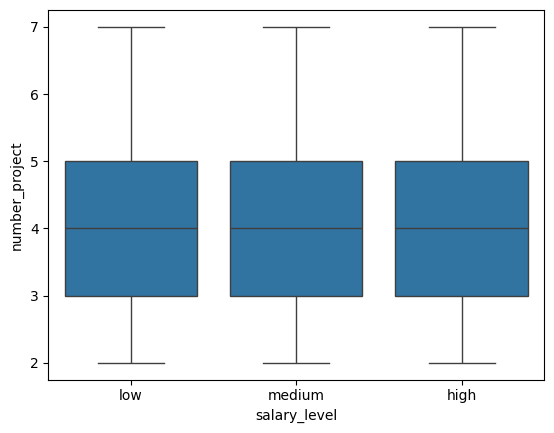

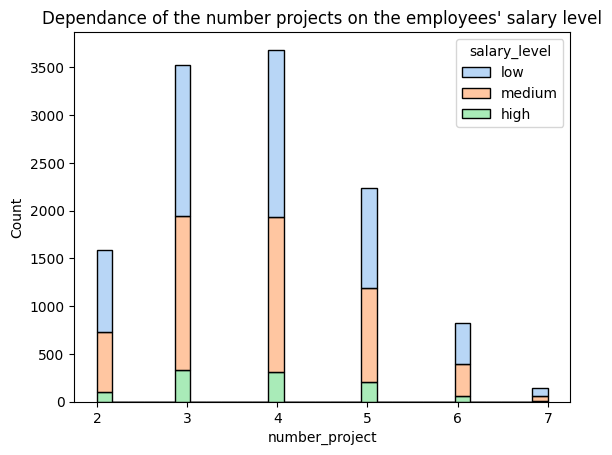

Text(0.5, 1.0, 'Number of projects histogram')

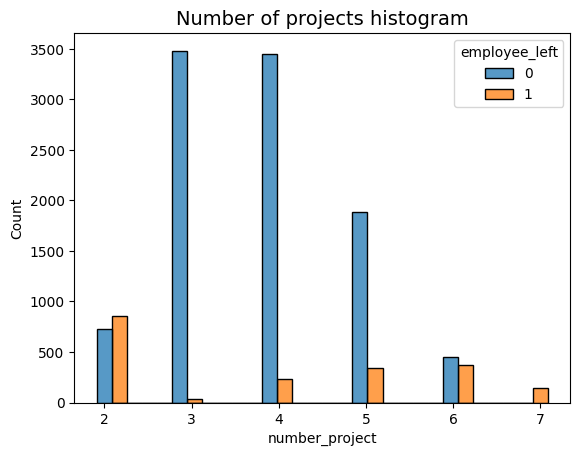

In [14]:
sns.boxplot(x='salary_level', y='number_project', data=df)
plt.show()


sns.histplot(data=df, stat="count", multiple="stack", x="number_project", kde=False, palette="pastel",
             hue="salary_level", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("number_project")
plt.ylabel("Count")
plt.title("Dependance of the number projects on the employees' salary level")
plt.show()

tenure_stay = df[df['employee_left']==0]['number_project']
tenure_left = df[df['employee_left']==1]['number_project']
sns.histplot(data=df, x='number_project', hue='employee_left', multiple='dodge', shrink=2)
plt.title('Number of projects histogram', fontsize='14')

In [15]:
# Let's confirm that employees who handling 7 projects were left
# Get value counts of employees with 7 projects who left

df[df['number_project']==7]['employee_left'].value_counts()

1    145
Name: employee_left, dtype: int64

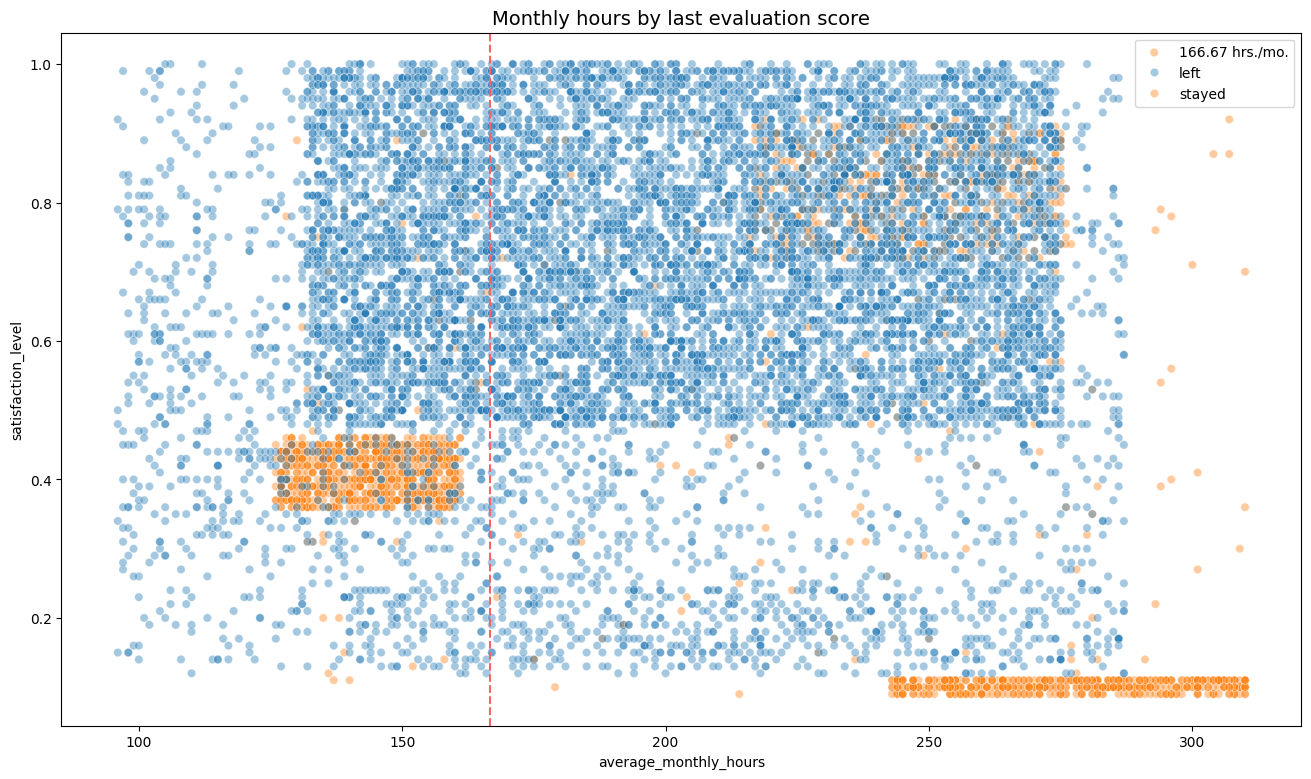

In [16]:
# scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='satisfaction_level', hue='employee_left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

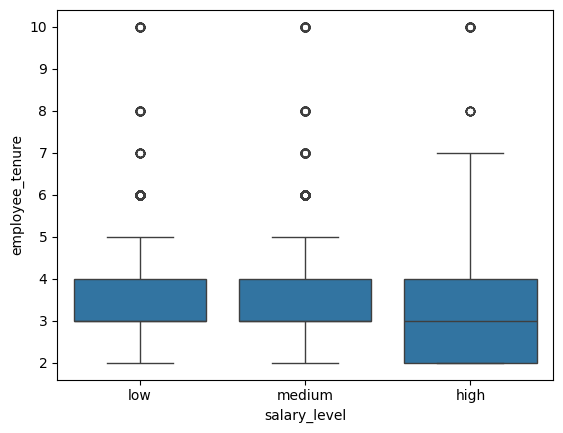

In [17]:
sns.boxplot(x='salary_level', y='employee_tenure', data=df)
plt.show()

0.440271220492215

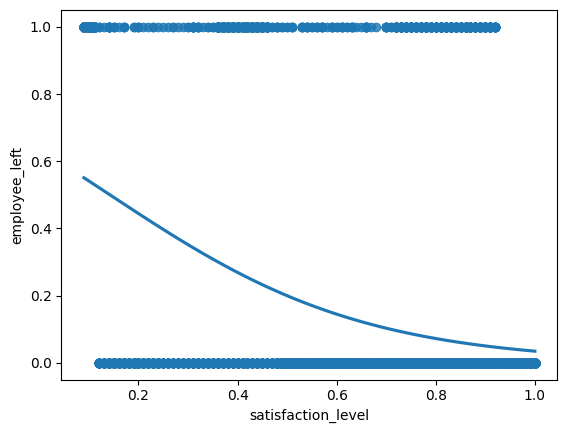

In [18]:
sns.regplot(x='satisfaction_level', y='employee_left', data=df, logistic=True, ci=None)

# average satisfaction level of employees who exited
avg_satisfaction = df[df['employee_left']==1]['satisfaction_level'].mean()
avg_satisfaction

In [19]:
# mean and median satisfaction scores of employees who left and those who stayed
df.groupby(['employee_left'])['satisfaction_level'].agg([np.mean,np.median])

,mean,median
employee_left,,
0,0.667365,0.69
1,0.440271,0.41


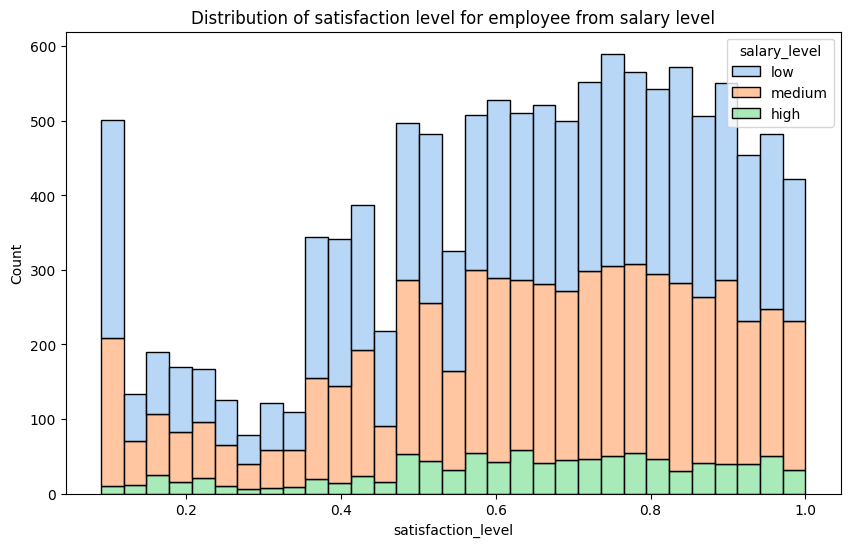

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, stat="count", multiple="stack", x="satisfaction_level", kde=False, palette="pastel",
             hue="salary_level", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("satisfaction_level")
plt.ylabel("Count")
plt.title("Distribution of satisfaction level for employee from salary level")
plt.show()

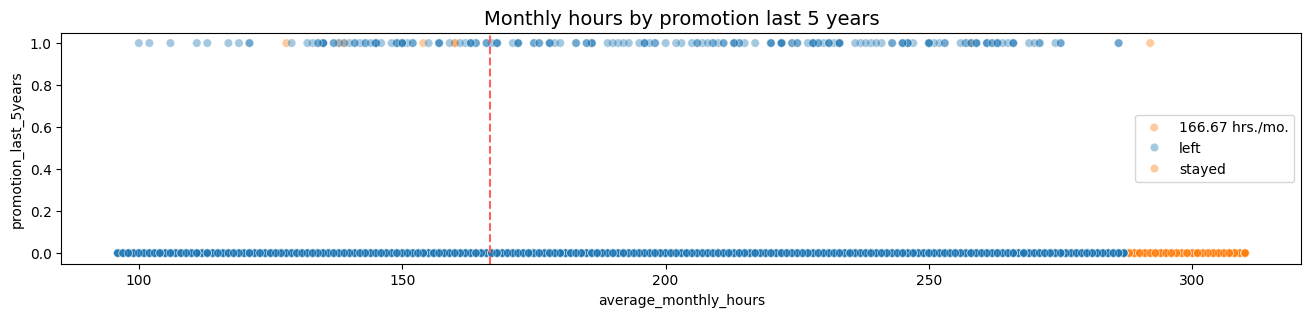

In [21]:
# plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df, x='average_monthly_hours', y='promotion_last_5years', hue='employee_left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

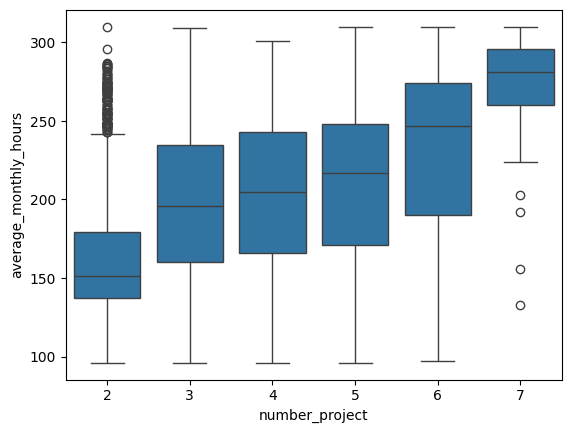

In [22]:
sns.boxplot(x='number_project', y='average_monthly_hours', data=df)
plt.show()

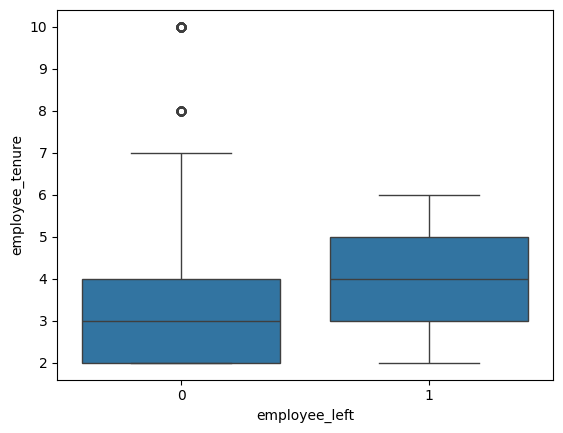

In [23]:
sns.boxplot(x='employee_left', y='employee_tenure', data=df)
plt.show()

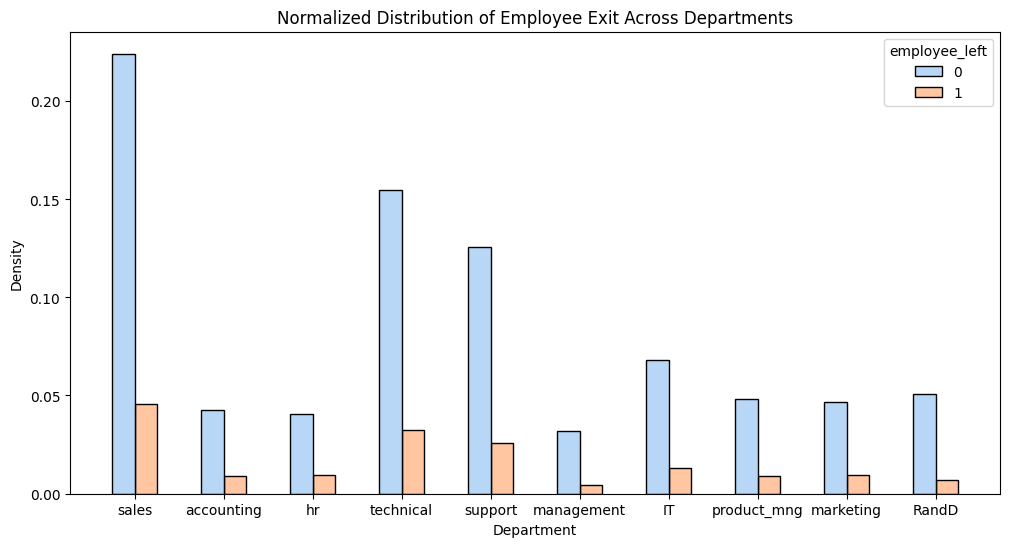

In [24]:
# Create two histograms in one plot
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="employee_department", hue="employee_left",
             stat="density",  # Normalize the histogram
             kde=False, palette="pastel",
             element="bars",
             multiple='dodge',
             shrink=.5, legend=True)
plt.title("Normalized Distribution of Employee Exit Across Departments")
plt.xlabel("Department")
plt.ylabel("Density")
plt.show()

In [25]:
# Display counts for each department
df["employee_department"].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: employee_department, dtype: int64

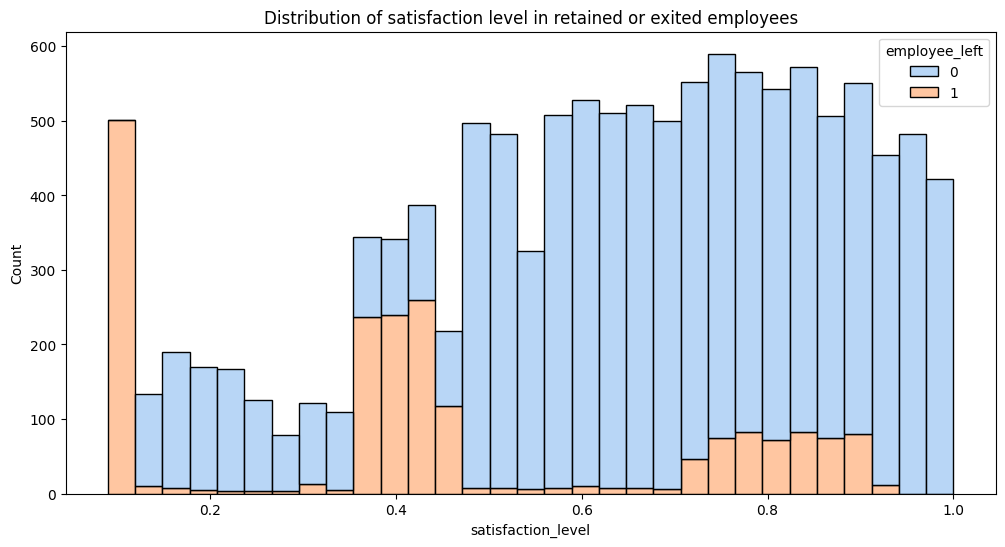

In [26]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, stat="count", multiple="stack", x="satisfaction_level", kde=False, palette="pastel",
             hue="employee_left", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("satisfaction_level")
plt.ylabel("Count")
plt.title("Distribution of satisfaction level in retained or exited employees")
plt.show()

Text(0.5, 1.0, 'Monthly hours by number of projects')

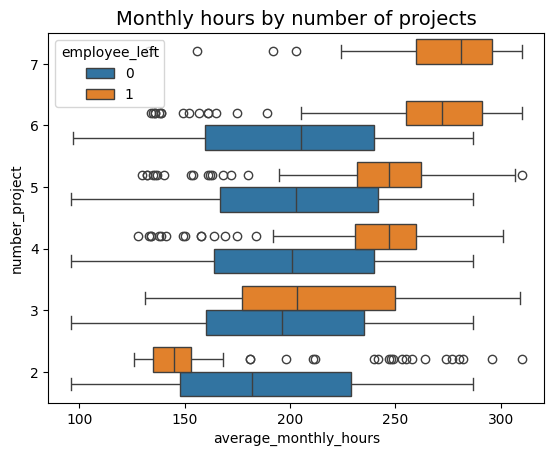

In [27]:
# boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
fig, ax = plt.subplots()
sns.boxplot(data=df, x='average_monthly_hours', y='number_project', hue='employee_left', orient="h")
ax.invert_yaxis()
plt.title('Monthly hours by number of projects', fontsize='14')

<ipython-input-28-040c44a6b130>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df0.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))


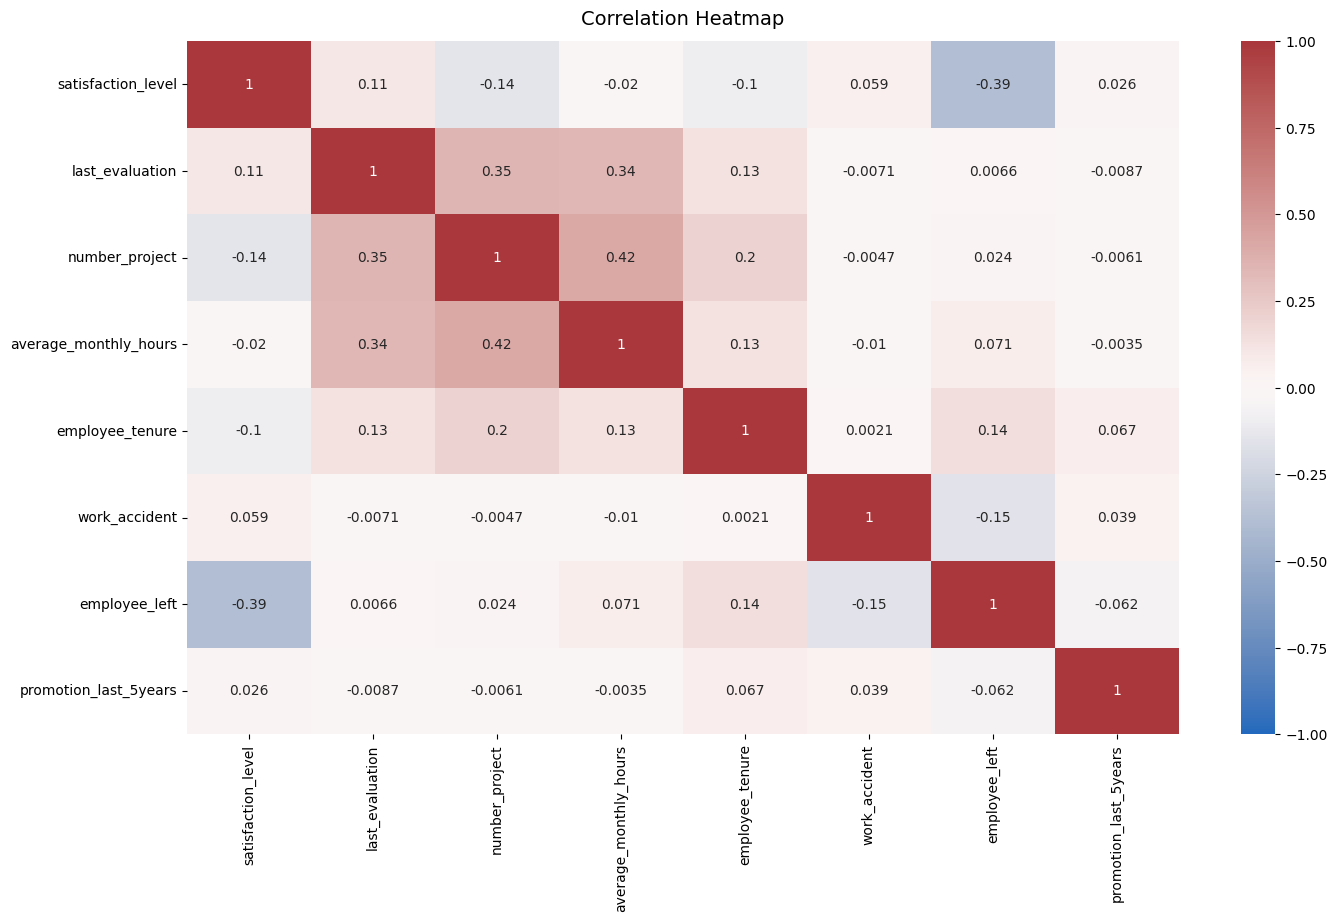

In [28]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df0.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

## Insights from EDA
There are few very interesting instights:

The satisfaction level is decreased for the exited employees, however some employees were left for different reason, because their satisfaction level was high.

In general, the satisfaction level of the employees for the salary is described as high even fot those who has low salary. However, there is a fraction with a clear correlation of low salary and low satisfaction level.

avarage number of hours per month increased with the number of projects.

employees who handling many projects at once (7) are at high risk to left.

employees who working very hard from ~240-315 hours / monthly or less than average number of hours / mounth (166.7 hours), from ~125 to 150 h/mounth are at high risk to left.

there was no correlation with the number of projects and salary level.

the majority of the employyes who exited worked at Sales and technical departments.

there is an indication that employee with prolonged tenure exited more often, however thare is some outliers in the retained group that hinding this conclusion

## Modeling

In [29]:
# Create a new df that drops employee_department column

exited_df = df.copy()

In [30]:
#Feature transformation
# Dummy encode categorical variables
# Encode the `salary` column as an ordinal numeric category
exited_df['salary_level'] = (
    exited_df['salary_level'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
exited_df = pd.get_dummies(exited_df, drop_first=True)
exited_df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,employee_tenure,work_accident,employee_left,promotion_last_5years,salary_level,employee_department_RandD,employee_department_accounting,employee_department_hr,employee_department_management,employee_department_marketing,employee_department_product_mng,employee_department_sales,employee_department_support,employee_department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


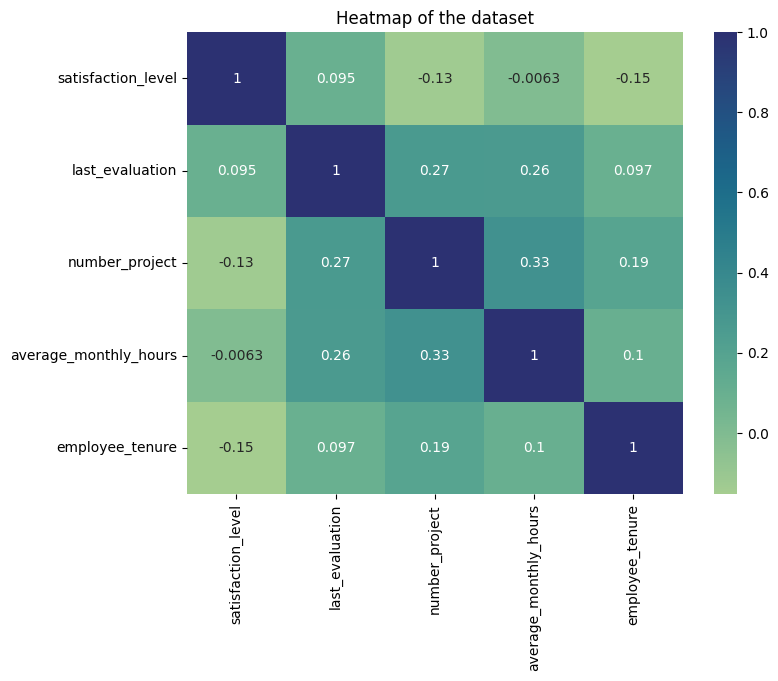

In [31]:
# heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(exited_df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'employee_tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [32]:
# Define the y (target) variable
y = exited_df['employee_left']

# Define the X (predictor) variables
X = exited_df.copy()
X = X.drop('employee_left', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, stratify=y,
                                                    random_state=42)

In [33]:
# Baseline decision tree model
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [34]:
print("Decision Tree")
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, dt_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, dt_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, dt_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, dt_pred))
print("AUC:", "%.6f" % metrics.roc_auc_score(y_test, dt_pred))

Decision Tree
Accuracy: 0.970647
Precision: 0.903543
Recall: 0.921687
F1 Score: 0.912525
AUC: 0.951043


<Axes: >

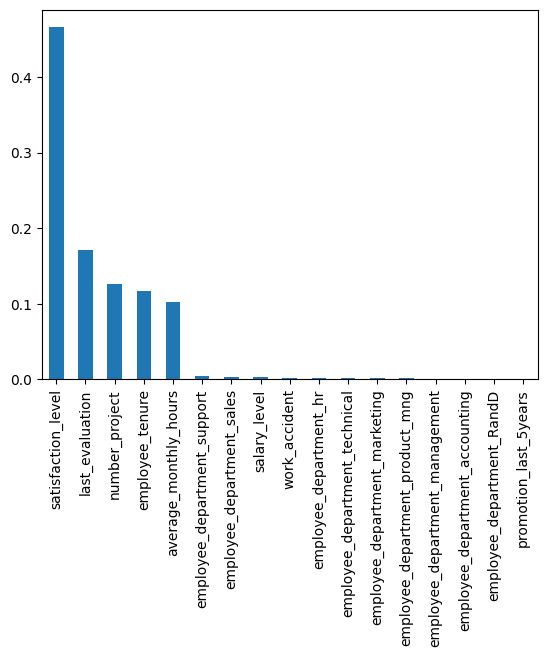

In [35]:
importances = decision_tree.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

In [36]:
# Hyperparameter tuning of the baseline model
tree_para = {'max_depth':[1,5,10,20,50],
             'min_samples_leaf': [2,4,6,8,10,20],
            'min_samples_split': [2, 4, 6]
            }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

In [37]:
%time
tuned_decision_tree = DecisionTreeClassifier(random_state=0)

clf = GridSearchCV(tuned_decision_tree,
                   tree_para,
                   scoring = scoring,
                   cv=5,
                   refit='roc_auc')

clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.6 µs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 5, 10, 20, 50],
                         'min_samples_leaf': [2, 4, 6, 8, 10, 20],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'recall', 'accuracy', 'roc_auc', 'f1', 'precision'})

In [38]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=8, random_state=0)

In [39]:
# Check best parameters
clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [40]:
#results = pd.DataFrame(columns=['Model', 'F1', 'Recall', 'Precision', 'Accuracy'])

def make_results(model_name, model_object):
    """
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    """

    # Get all the results from the CV and put them in a df.
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score).
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row.
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    auc = best_estimator_results.mean_test_roc_auc


    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy],
                          'Auc': [auc]
                         }
                        )

    return table


result_table = make_results("Tuned Decision Tree", clf)

result_table

,Model,F1,Recall,Precision,Accuracy,Auc
0,Tuned Decision Tree,0.945271,0.920287,0.971875,0.982319,0.960125


In [41]:
# Random Forest Model
%time

rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [125, 150, 300]
            }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf_cv1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='roc_auc')

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs


In [42]:
rf_cv1.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [125, 150, 300]},
             refit='roc_auc',
             scoring={'recall', 'accuracy', 'roc_auc', 'f1', 'precision'})

In [43]:
# Define a path to the folder where you want to save the model
path = 'your_path'

In [44]:
# Define functions to pickle the model and read in the model.

def write_pickle(path, model_object, save_as:str):
    '''
    In:
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [45]:
def read_pickle(path, saved_model_name:str):
    '''
    In:
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out:
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [ ]:
# Use the functions defined above to save the model in a pickle file and then read it in.
# Write pickle
write_pickle(path, rf_cv, 'hr_rf_cv')

In [ ]:
# Read pickle
rf_cv1 = read_pickle(path, 'hr_rf_cv')

In [48]:
rf_cv1.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [49]:
rf_cv1.best_score_

0.9822721936656865

In [54]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Isolate the row of the df with the max(metric) score
    # best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    auc = best_estimator_results.mean_test_roc_auc

    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy],
                          'Auc': [auc]
                         }
                        )

    return table

In [55]:
# Make a results table for the rf_cv model using above function
rf_cv_results1 = make_results('Random Forest CV', rf_cv1)
rf_cv_results1

,Model,F1,Recall,Precision,Accuracy,Auc
0,Random Forest CV,0.946646,0.909569,0.986971,0.982987,0.979713


In [56]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate).
    Returns a plot of confusion matrix for predictions on y data.
    '''

    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)

    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

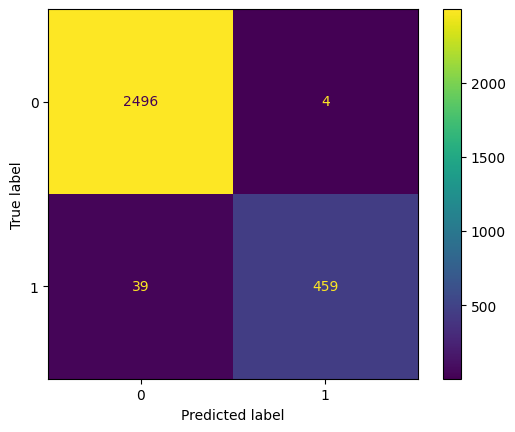

In [57]:
# Generate confusion matrix
conf_matrix_plot(rf_cv1, X_test, y_test)

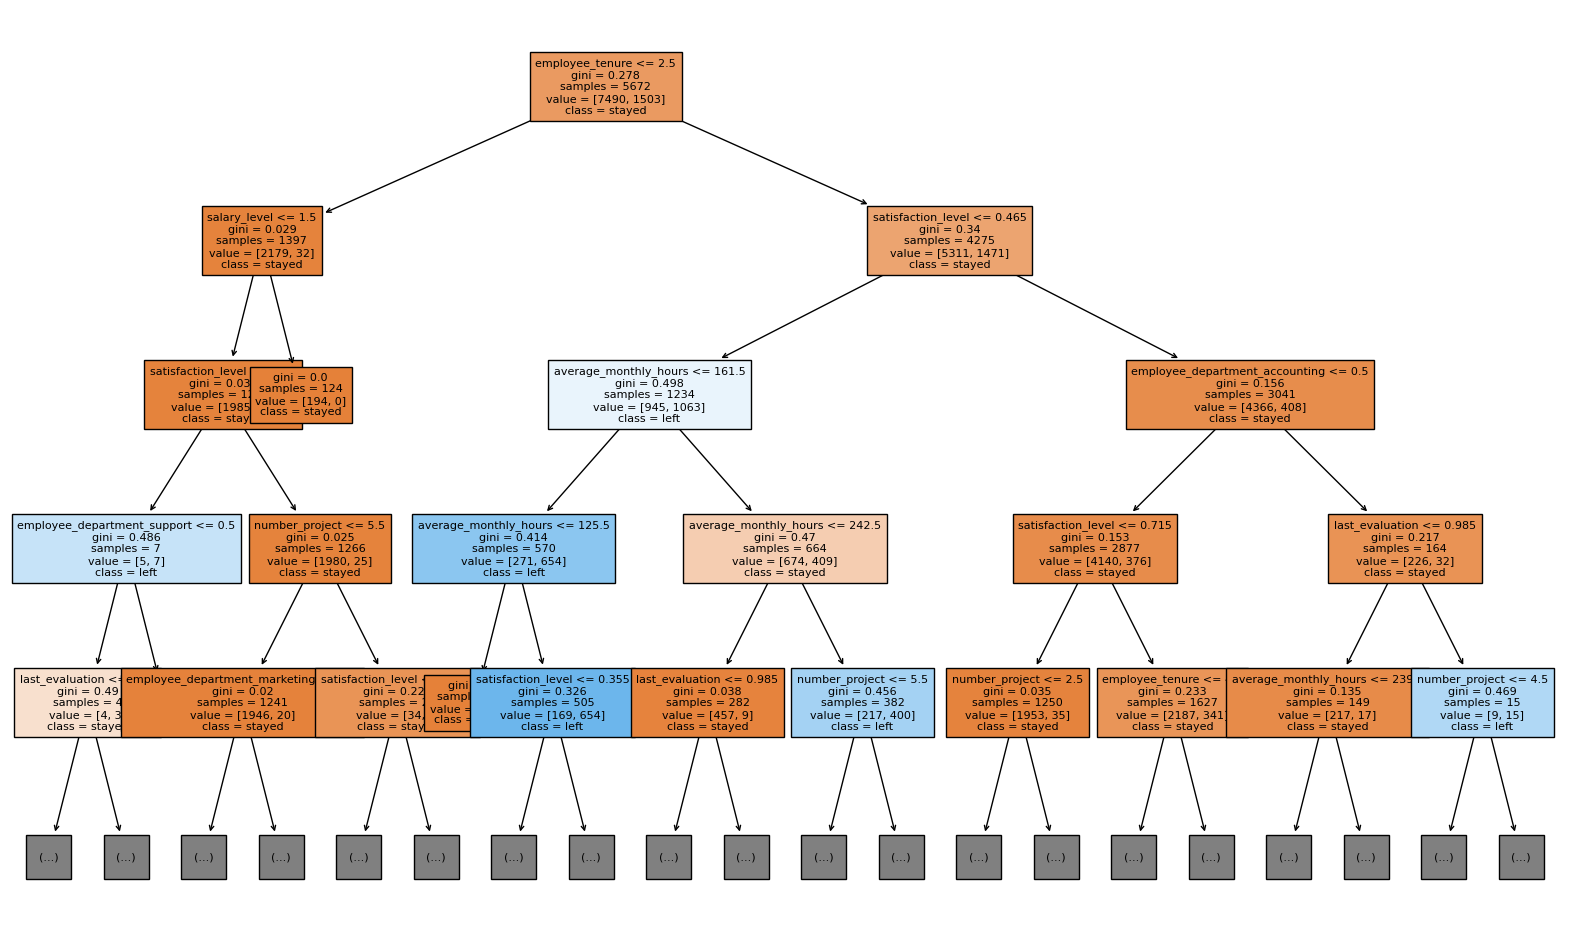

In [58]:
# Plot the tree
best_rf = rf_cv1.best_estimator_

# Select one of the trees from the random forest (for example, the first tree)
single_tree = best_rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 12))
plot_tree(single_tree, max_depth=4, fontsize=8, feature_names=X.columns,
          class_names=['stayed', 'left'], filled=True)
plt.show()

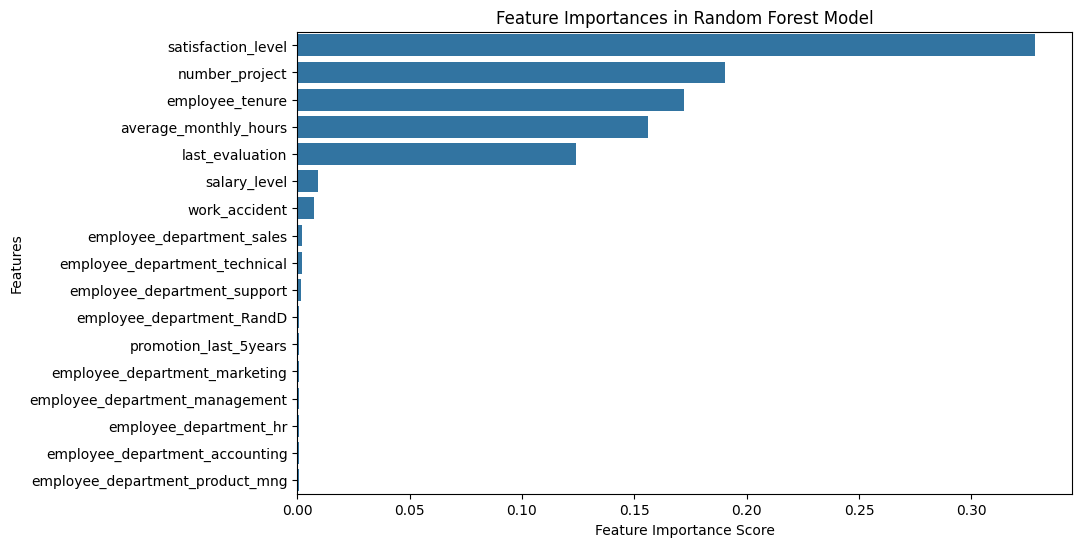

In [59]:
# Access the best estimator from your grid search
best_rf_model = rf_cv1.best_estimator_

# Retrieve feature importances from the best estimator
importances = best_rf_model.feature_importances_

# Create a pandas Series with the feature importances
feature_importances = pd.Series(importances, index=X.columns)

# Sort the features by importance for better visualization
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted, y=feature_importances_sorted.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances in Random Forest Model')
plt.show()

In [60]:
# Concatenate the decision tree and random forest results to one table
results = pd.concat([result_table, rf_cv_results1])
results

,Model,F1,Recall,Precision,Accuracy,Auc
0,Tuned Decision Tree,0.945271,0.920287,0.971875,0.982319,0.960125
0,Random Forest CV,0.946646,0.909569,0.986971,0.982987,0.979713


In [61]:
# The model is doing so well that it is suspected that there is some data leakage from training to test dataset.
# One of the possible way for data leakage is satisfaction column. the most important feature for the model.
# Let's drop it out and check the model performance.

df1= exited_df.drop(['satisfaction_level'], axis=1)
df1

,last_evaluation,number_project,average_monthly_hours,employee_tenure,work_accident,employee_left,promotion_last_5years,salary_level,employee_department_RandD,employee_department_accounting,employee_department_hr,employee_department_management,employee_department_marketing,employee_department_product_mng,employee_department_sales,employee_department_support,employee_department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.55,3,259,10,1,0,1,2,0,0,0,1,0,0,0,0,0
11996,0.95,5,266,10,0,0,1,2,0,0,0,1,0,0,0,0,0
11997,0.54,3,185,10,0,0,1,2,0,0,0,1,0,0,0,0,0
11998,0.65,3,172,10,0,0,1,2,0,0,0,0,1,0,0,0,0


In [62]:
# Define the y (target) variable
y = df1['employee_left']

# Define the X (predictor) variables
X = df1.copy()
X = X.drop('employee_left', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, stratify=y,
                                                    random_state=42)

In [63]:
rf_cv1.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [64]:
# Random Forest Model
%time

rf2 = RandomForestClassifier(random_state=0)

cv_params1 = {'max_depth': [None],
             'min_samples_leaf': [3,4],
             'min_samples_split': [1,2],
             'max_features': [3,4],
             'n_estimators': [125, 150]
            }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf_cv2 = GridSearchCV(rf2, cv_params1, scoring=scoring, cv=5, refit='roc_auc')

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


In [65]:
rf_cv2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None], 'max_features': [3, 4],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [1, 2],
                         'n_estimators': [125, 150]},
             refit='roc_auc',
             scoring={'recall', 'accuracy', 'roc_auc', 'f1', 'precision'})

In [66]:
rf_cv2.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 125}

In [67]:
rf_cv2.best_score_

0.9761984399901236

In [68]:
# Make a results table for the rf_cv1 model using above function
rf_cv_results2 = make_results('Random Forest CV_2', rf_cv2)
rf_cv_results2

,Model,F1,Recall,Precision,Accuracy,Auc
0,Random Forest CV_2,0.914257,0.889486,0.940523,0.972312,0.975498


In [69]:
results = pd.concat([result_table, rf_cv_results1, rf_cv_results2])
results

,Model,F1,Recall,Precision,Accuracy,Auc
0,Tuned Decision Tree,0.945271,0.920287,0.971875,0.982319,0.960125
0,Random Forest CV,0.946646,0.909569,0.986971,0.982987,0.979713
0,Random Forest CV_2,0.914257,0.889486,0.940523,0.972312,0.975498


## Summary of model results
The results in the table above with the evaluation metrics tell us that the cross-validated random forest model performs very well for all the metrics, including roc_auc, precision, recall, F1 and accuracy.

An AUC metric is queal to 0.98 for both rounds of Random Forest model, indicating that the model has a good measure of separability and is very capable of distinguishing between the positive class (e.g., employees who left the company) and the negative class (e.g., employees who stayed). In other words, the model can correctly identify a high rate of true positives (correctly predicting the employees who will leave) while maintaining a low false positive rate (not misclassifying those who will stay as leaving).

The recall is 0.9095 for 1st Random Forest and 0.889 for the 2nd Random Forest model (without satisfaction column). This means that out of all the employees in the validation folds who actually left the company, the models successfully identifies 90.9% or 88.9% of them.

Precision measures the accuracy of the positive predictions. The precision is 0.9829 means that when the model predicts that an employee will leave the company, it is correct approximately 98.29% of the time. This is a very high precision score, indicating that the model is very effective at correctly identifying the true cases of employees leaving, with a very low false positive rate.

The F1 score is a harmonic mean of precision and recall, providing a balance between them. It is particularly useful when the class distribution is imbalanced as in our model. An F1 score of 0.9466 is excellent, suggesting that the model achieves a great balance between precision and recall. This score indicates that the model doesn't overly favor either recall or precision, making it reliable for both identifying most of the true positives (employees who left) and maintaining a low rate of false positives (employees who are predicted to leave but don't).

In summary, Random Forest model demonstrates high performance across all the evaluated metrics. The high precision indicates that it's very reliable in its positive predictions (identifying employees who will leave), while the high recall shows that it also successfully identifies most of the actual positive cases. The F1 score confirms the model's balanced performance in terms of precision and recall.

## Conclusion, Recommendations, Next Steps¶
The decision tree visualization from the Random Forest model provides insights into the features that are most important in predicting employee turnover. Based on the tree's splits, we can infer which features and their thresholds are influential in predicting whether an employee is likely to leave the company. Here are some observations and recommendations for the HR department based on the Random Forest CV model:

HR could look into work distribution and ensure employees are engaged with a satisfactory number of projects to maintain motivation and reduce turnover. Cap the number of projects that employees can work on.

HR should offering a promotion to employees who have reached at least four years of service, or alternatively, delve into a deeper analysis to understand the reasons behind the dissatisfaction among employees at this four-year service mark. Develop targeted employee engagement and retention programs. These could include career development opportunities, mentorship programs, and regular check-ins, particularly for those at risk of leaving.

Consider providing incentives to employees for extended work hours, or alternatively, avoid mandating overtime. By acknowledging and rewarding employees for their accomplishments and commitment, organizations can foster a positive and motivating work environment.

Reevaluate the expectations and workload to ensure that extended hours are not consistently required. It's important to prioritize a healthy work-life balance and avoid creating an environment where excessive hours are the primary measure of dedication and performance. Regularly review employees' workloads to ensure a fair and balanced distribution. Overburdening employees can lead to burnout, while underutilization can lead to disengagement.